Sascha Spors,
Professorship Signal Theory and Digital Signal Processing,
Institute of Communications Engineering (INT),
Faculty of Computer Science and Electrical Engineering (IEF),
University of Rostock,
Germany

# Tutorial Digital Signal Processing

**IIR Filter**,
Winter Semester 2020/21 (Course #24505

- lecture: https://github.com/spatialaudio/digital-signal-processing-lecture
- tutorial: https://github.com/spatialaudio/digital-signal-processing-exercises

Feel free to contact lecturer frank.schultz@uni-rostock.de

WIP...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
from scipy import signal

np.set_printoptions(precision=16)

In [2]:
def zplane_plot(ax, z, p):
    """Realize a zplane plot.

    input:
    ax...axes handle
    z...zeros
    p...poles
    output:
    zplane plot into ax
    """
    if ax is None:
        ax = plt.gca()

    ax.axvline(0, color="C7")
    ax.axhline(0, color="C7")
    unit_circle = Circle((0, 0), radius=1, fill=False,
                         color="k", linestyle="-", alpha=1)
    ax.add_patch(unit_circle)

    ax.plot(np.real(z), np.imag(z),
            "o", label="zero",
            color="C0", fillstyle="none",
            markersize=10, markeredgewidth=2)
    ax.plot(np.real(p), np.imag(p),
            "x", label="pole",
            color="C1", fillstyle="none",
            markersize=10, markeredgewidth=2)

    if len(z) == 2 and len(p) == 2:
        if (z[0]-z[1]) == 0.:
            ax.text(np.real(z[0])+0.05, np.imag(z[0])+0.05, '2', color='C0')
        if (p[0]-p[1]) == 0.:
            ax.text(np.real(p[0])+0.05, np.imag(p[0])-0.1, '2', color='C1')
    else:
        if len(z) != 1 and len(p) != 1:
            ax.text(-1.1, -1.1,
                    'warning: multiple zeros or poles might be in the pzmap')

    ax.set_xscale("linear")
    ax.set_yscale("linear")
    ax.set_xlabel(r'$\Re(z)$', color="k")
    ax.set_ylabel(r'$\Im(z)$', color="k")
    ax.set_title("Pole/zero map",
                 color="k")
    ax.axis("equal")
    ax.set_xticks(np.arange(-2, 3)/2)
    ax.set_yticks(np.arange(-2, 3)/2)
    ax.legend(loc="best")
    ax.grid(True, which="both", axis="both",
            linestyle="-", linewidth=0.5, color=(0.8, 0.8, 0.8))


def bode_plot(b, a, N=2**10, fig=None):  # for IIR if length of b and a are the same
    if fig is None:
        fig = plt.figure()

    p = np.roots(a)
    z = np.roots(b)

    #print('#poles:', len(p), '\n poles:', p,
    #      '\n#zeros:', len(z), '\n zeros:', z)

    W, Hd = signal.freqz(b, a, N, whole=True)
    if Hd[0] == 0:
        Hd[0] = 1e-15  # avoid zero at DC for plotting dB

    gs = fig.add_gridspec(2, 2)
    # magnitude
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(W/np.pi, np.abs(Hd), "C7",
             label=r'$|H(\Omega)|$)',
             linewidth=2)
    ax1.set_xlim(0, 2)
    ax1.set_xticks(np.arange(0, 9)/4)
    ax1.set_xlabel(r'$\Omega / \pi$', color='k')
    ax1.set_ylabel(r'$|H|$', color='k')
    ax1.set_title("Magnitude response", color='k')
    ax1.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color=(0.8, 0.8, 0.8))

    # phase
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(W/np.pi, (np.angle(Hd)*180/np.pi), "C7",
             label=r'$\mathrm{angle}(H('r'\omega))$',
             linewidth=2)
    ax2.set_xlim(0, 2)
    ax2.set_xticks(np.arange(0, 9)/4)
    ax2.set_xlabel(r'$\Omega / \pi$', color='k')
    ax2.set_ylabel(r'$\angle(H)$ / deg', color='k')
    ax2.set_title("Phase response", color='k')
    ax2.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color=(0.8, 0.8, 0.8))

    # zplane
    ax3 = fig.add_subplot(gs[0, 1])
    zplane_plot(ax3, z, p)

    # impulse response
    N = 2**4
    k = np.arange(0, N)
    x = np.zeros(N)
    x[0] = 1
    h = signal.lfilter(b, a, x)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.stem(k, h, linefmt='C7', markerfmt='C7o',
             basefmt='C7:', use_line_collection=True)
    ax4.set_xlabel(r'$k$')
    ax4.set_ylabel(r'$h[k]$')
    ax4.set_title('Impulse Response')
    ax4.grid(True, which="both", axis="both", linestyle="-",
             linewidth=0.5, color=(0.8, 0.8, 0.8))

figsize = (12, 9)

In [3]:
# taken from lecture's repository
# https://github.com/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/audiofilter.py


def bilinear_biquad(B, A, fs):
    """Get the bilinear transform of a 2nd-order Laplace transform.

    bilinear transform H(s)->H(z) with s=2*fs*(z-1)/(z+1)

    input:
    B[0] = B0   B[1] = B1   B[2] = B2
    A[0] = A0   A[1] = A1   A[2] = A2
    fs...sampling frequency in Hz
           Y(s)   B0*s^2+B1*s+B2   B[0]*s^2+B[1]*s+B[2]
    H(s) = ---- = -------------- = --------------------
           X(s)   A0*s^2+A1*s+A2   A[0]*s^2+A[1]*s+A[2]
    output:
    b[0] = b0   b[1] = b1   b[2] = b2
    a[0] = 1    a[1] = a1   a[2] = a2
           Y(z)   b2*z^-2+b1*z^-1+b0   b[2]*z^-2+b[1]*z^-1+b[0]
    H(z) = ---- = ------------------ = ------------------------
           X(z)   a2*z^-2+a1*z^-1+ 1   a[2]*z^-2+a[1]*z^-1+a[0]
    """
    A0, A1, A2 = A
    B0, B1, B2 = B
    fs2 = fs**2

    a0 = A2 + 2*A1*fs + 4*A0*fs2
    b0 = B2 + 2*B1*fs + 4*B0*fs2

    b1 = 2*B2 - 8*B0*fs2
    a1 = 2*A2 - 8*A0*fs2

    b2 = B2 - 2*B1*fs + 4*B0*fs2
    a2 = A2 - 2*A1*fs + 4*A0*fs2

    b = np.array([b0, b1, b2]) / a0
    a = np.array([a0, a1, a2]) / a0

    return b, a


def f_prewarping(f, fs):
    """Do the frequency prewarping for bilinear transform.

    input:
    f...analog frequency in Hz to be prewarped
    fs...sampling frequency in Hz
    output:
    prewarped angular frequency wpre in rad/s
    """
    return 2*fs*np.tan(np.pi*f/fs)

# Filter Fundamentals

The transfer function of digital filters can be expressed in the $z$-domain as
\begin{equation}
H(z)=\frac{Y(z)}{X(z)} = \frac{\sum\limits_{m=0}^M b_mz^{-m}}{\sum\limits_{n=0}^N a_nz^{-n}}
=\frac{b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}}{a_0z^0+a_1z^{-1}+a_2z^{-2}+...+a_Nz^{-N}}
\end{equation}

with input $z$-function $X(z)$ and output $Y(z)$. Real input signals $x[k]$ that should end up as real output signals $y[k]$ require $b,a\in\mathbb{R}$. In terms of signal processing fundamentals this is just a special case, though most often needed in practice. This only yields the following types of zeros and poles

- single or multiple real valued
- single or multiple conjugate-complex pairs

Furthermore, in practice we most often aim at (i) causal and (ii) bounded input, bound output (BIBO) stable LTI systems, which requires (i) $M \leq N$ and (ii) all poles inside the unit circle. If all poles and zeros are inside the unit circle then the system is minimum-phase and thus straightforwardly invertible.

Further concepts related to the transfer function are:

- Analysis of the transfer characteristics is done by the DTFT
$H(z=\mathrm{e}^{\mathrm{j}\Omega})$, i.e. evaluation on the unit circle.

- We use $a_0=1$ according to convention in many textbooks.

- The convention for arraying filter coefficients is straightforward since Python starts indexing with zero:
$b_0=b[0]$, $b_1=b[1]$, $b_2=b[2]$, ..., $a_0=a[0]=1$, $a_1=a[1]$, $a_2=a[2]$.

- A **non-recursive** system with $a_1,a_2,a_3,...=0$ exhibits a **finite
impulse response** (FIR), note: $a_0=1$ for output though.

- A **recursive system** exhibits at least one $a_{n\geq1}\neq0$. Because
of the feedback of the output signal into the system, a potentially **infinite impulse
response** (IIR) results.

- The output signal of a non-recursive system can be calculated by linear
convolution 

\begin{equation}
y[k] = \sum\limits_{m=0}^{M} h[k] x[k-m].
\end{equation}

of the finite impulse response $h[k]=[b_0, b_1, b_2,...,b_M]$ and the input signal $x[k]$.

- The output of a recursive system needs to be calculated by the difference equation

\begin{equation}
y[k] = b_0 x[k] + b_1 x[k-1] + b_2 x[k-2] + ... + b_M x[k-M] -a_1 y[k-1] - a_2 y[k-2] - a_3 y[k-3] - ... - a_N y[k-N].
\end{equation}

In rare cases the respsonse can be derived analytically. This is often approached to calculate the impulse response (i.e. $x[k] = \delta[k]$) analytically via inverse $z$-transform.

Please note: A recursive system can still have a finite impulse response, but those are very special cases. Therefore, literature usually makes the distinction for FIR being non-recursive and IIR being recursive systems.

## Pole Zero Placement Examples for IIR Filters of 2nd Order

Let's define a small function where we can define a complex zero $z_0 = z_r \mathrm{e}^{\mathrm{j} z_a}$ and a complex pole $p_0 = p_r \mathrm{e}^{\mathrm{j} p_a}$ and the function finds the complex conjugates, the IIR filter coefficients $b$ and $a$ and plots magnitude, phase response, pole/zero map and impulse response.

In [4]:
def pz_placement(zr, za, pr, pa):
    z = zr * np.exp(+1j*za)
    p = pr * np.exp(+1j*pa)
    
    b = np.poly([z, np.conj(z)])
    a = np.poly([p, np.conj(p)])
    
    bode_plot(b, a, fig=plt.figure(figsize=figsize))

Then we can play around with some pole/zero alignments.

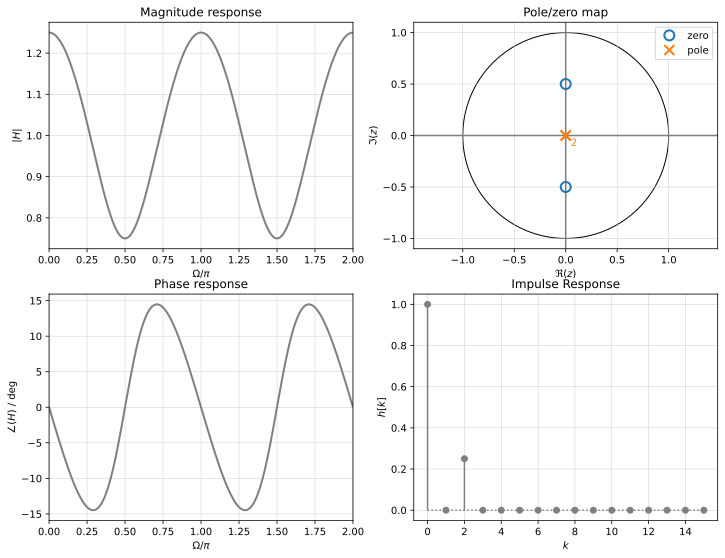

In [5]:
pz_placement(zr=1/2, za=np.pi/2, pr=0, pa=0)  # FIR filter, poles in origin

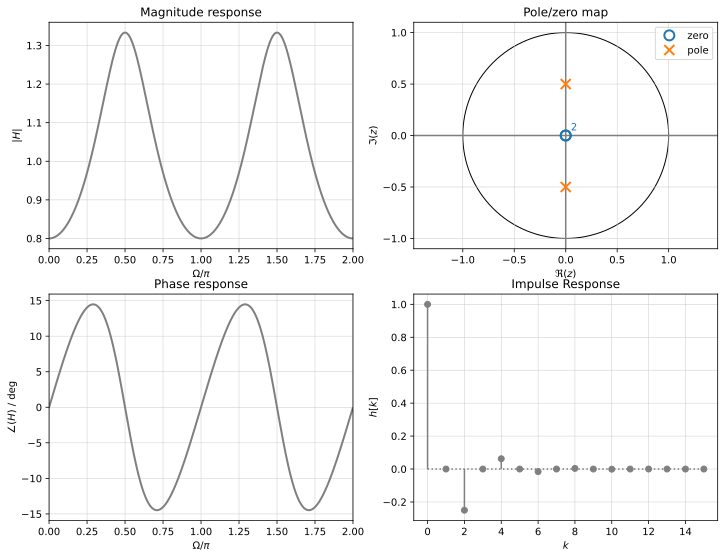

In [6]:
pz_placement(zr=0, za=0, pr=1/2, pa=np.pi/2)  # filter from above inverted
# this yields an IIR filter

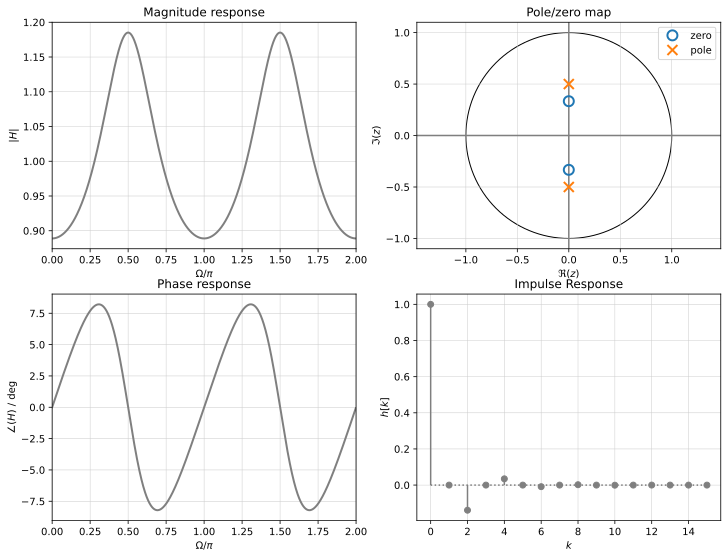

In [7]:
pz_placement(zr=1/3, za=np.pi/2, pr=1/2, pa=np.pi/2)  # shift zeros closer to poles
# less ripple in magnitude response, note that y-axis has changed 

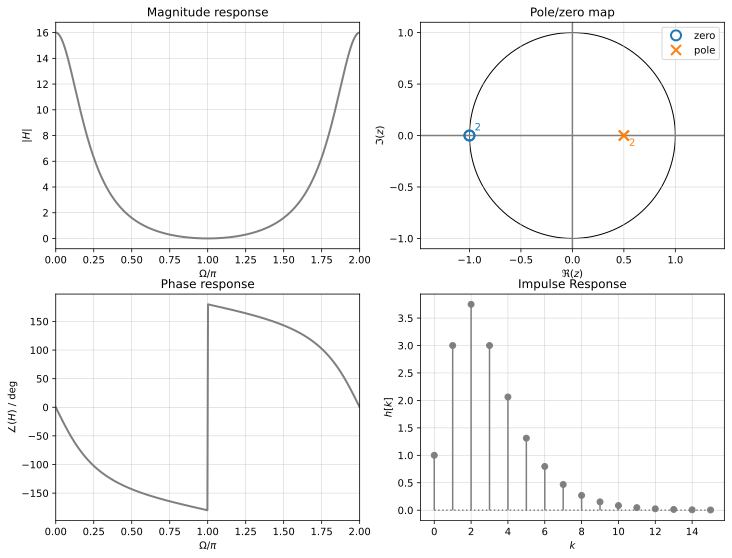

In [8]:
pz_placement(zr=1, za=np.pi, pr=1/2, pa=0)  # 2nd order lowpass filter
# special here is: zero at -1 thus amplitude 0 at fs/2
# two real poles at same location

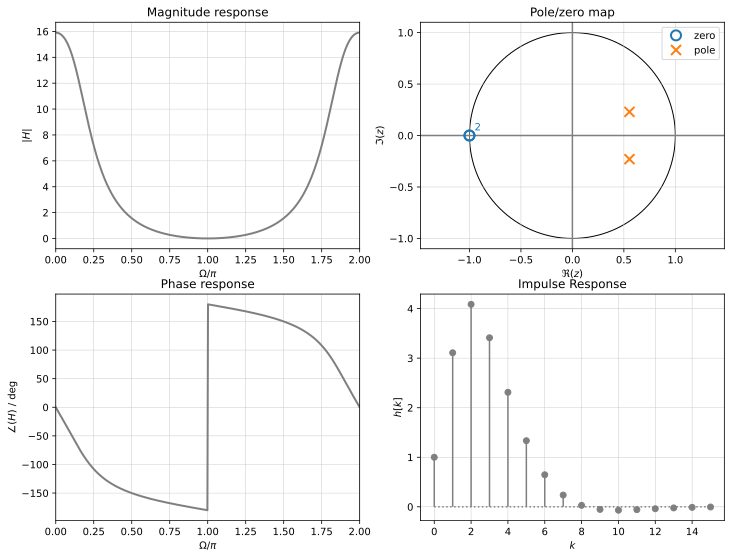

In [9]:
pz_placement(zr=1, za=np.pi, pr=3/5, pa=np.pi/8)  # 2nd order lowpass filter
# zero at -1 thus amplitude 0 at fs/2
# this time complex conjugate pole pair to yield about the same magnitude
# at DC
# check the differences between the two filters

# Filter Design with Bilinear Transform

## Mapping

A Laplace transfer function can be transformed to $z$-domain transfer function by 

\begin{equation}
s=2f_s\frac{z-1}{z+1}.
\end{equation}

This is known as bilinear transform.

There are severeal derivations for this mapping. One way, that engineers could probably like most, is to linearize a function, namely applying the Tayor series and then taking only the linear term.

So, we know that the exact link between $s$ and $z$ is given by the definion
\begin{equation}
z = \mathrm{e}^{\,s T}
\end{equation}
using the sampling interval $T = \frac{1}{f_s}$. The inverse function is 
\begin{equation}
s = \frac{1}{T} \cdot \ln (z).
\end{equation}
The Taylor series of the logarithm is known as
\begin{equation}
\ln(z) = 2 \left( \frac{z-1}{z+1} + \frac{(z-1)^3}{3(z+1)^3} + \frac{(z-1)^5}{5(z+1)^5} + \dots \right).
\end{equation}
Considering the linear term only yields the mapping introduced above.

## Characteristics
- left $s$-half plane mapped to the unit circle in $z$-domain
- right $s$-half plane mapped to outer unit circle in $z$-domain
- thus, stable analog filters ($s$-domain) yield stable discrete-time filters ($z$-domain)
- $s=0$ is mapped to $z=1$
- infinite, positive $\mathrm{j}\omega$ axis of $s$-domain is mapped to the upper unit circle
- infinite, negative $\mathrm{j}\omega$ axis of $s$-domain is mapped to the lower unit circle
- $n$-th order filter in $s$-domain yields also $n$-th filter in $z$-domain, due to same powers of $s$ and $z$ in the mapping. Question: what happens if one uses more terms of the Taylor approximation.

When rearranging the mapping to 
\begin{equation}
z = \frac{2 + s T}{2 - s T}
\end{equation}
we can see, what happens for $s = \pm \mathrm{j}\omega$ with $\omega\rightarrow\infty$. In both cases the mapping $z=-1$ is achieved. This make the upper/lower semi-circle obvious.

## Non-Linear Mapping of Frequency Axis

Evaluating $s$- and $z$-plane along their frequency axis, i.e. setting $s=\mathrm{j}\omega$ and $z = \mathrm{e}^{\mathrm{j}\Omega}$, the mapping $s=2f_s\frac{z-1}{z+1}$ becomes

\begin{equation}
\mathrm{j}\omega=2f_s\frac{\mathrm{e}^{\mathrm{j}\Omega}-1}{\mathrm{e}^{\mathrm{j}\Omega}+1}.
\end{equation}

This can be rearranged to

\begin{equation}
\omega = 2 f_s \tan{\frac{\Omega}{2}}
\end{equation}

and to its inverse function

\begin{equation}
\Omega = 2 \mathrm{atan}{\frac{\omega}{2 f_s}}.
\end{equation}

We see that the mapping between analog angular frequency and discrete-time frequency is non-linear in the bilinear transform.

For the example given below, consider the tan-mapping in the left plot:

A digtial bandwidth from $0 < \Omega < 1$ maps approximately to $0 < \omega < 1$, the digital bandwidth
$1 < \Omega < 2$ however maps to $1 < \omega < 3$ in analog domain. For digital bandwitdh $2 < \Omega < 3$ this bandwidth mismatch gets even worse and is not depicted in the graph anymore.

Digital to analog bandwidth mapping: the higher the digital frequency, the larger the bandwidth mismatch compared to analog domain becomes, analog bandwidth appears larger.

Now, consider the atan-mapping in the right plot:

An analog bandwidth from $0<\omega<1$ maps approximately to $0<\Omega<1$, we should expect this, since this is the region where tan() and atan() are approximately linear.
However, an analog bandwidth from $1<\omega<2$ maps approximately to $1<\Omega<\frac{3}{2}$, meaning that the digital bandwidth gets squeezed.

Thus, analog to digital bandwidth mapping: the higher the analog frequency, the larger the bandwidth mismatch compared to digital domain becomes, digital bandwidth appears smaller.

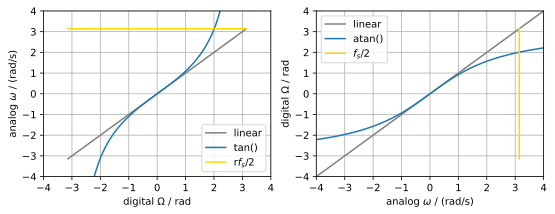

In [10]:
plt.figure(figsize=(9,3))

fs = 1  # sampling frequency in Hz
N = 2**8

plt.subplot(1,2,1)
W = np.arange(-N, N) * np.pi/N
w = 2*fs*np.tan(W/2)
plt.plot(W, W, 'C7', label='linear')
plt.plot(W, w, label='tan()')
plt.plot([-np.pi, np.pi], [2*np.pi*fs/2, 2*np.pi*fs/2], color='gold', label='r$f_s/2$')
plt.xlim(-np.pi, +np.pi)
plt.ylim(-4, 4)
plt.xticks(np.arange(-4,5,1))
plt.yticks(np.arange(-4,5,1))
plt.xlabel(r'digital $\Omega$ / rad')
plt.ylabel(r'analog $\omega$ / (rad/s)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
w = np.arange(-N, N) * 10/N
W = 2*np.arctan(w/(2*fs))
plt.plot(w, w, 'C7', label='linear')
plt.plot(w, W, label='atan()')
plt.plot([2*np.pi*fs/2, 2*np.pi*fs/2], [-np.pi, np.pi], color='gold', label=r'$f_s/2$')
plt.xlim(-4, +4)
plt.ylim(-np.pi, +np.pi)
plt.xticks(np.arange(-4,5,1))
plt.yticks(np.arange(-4,5,1))
plt.xlabel(r'analog $\omega$ / (rad/s)')
plt.ylabel(r'digital $\Omega$ / rad')
plt.legend()
plt.grid(True)

There is no way to avoid these non-linear mapping effects, they come inherently with the application of the bilinear transform.
However, one can be cautious in filter design having three options:

1. Make sure that the bandwidth(s) under discussion are far away from half of the sampling frequency. Or in other words, try to work in the linear-like part of the tan/atan-mapping functions
2. Since 1. cannot be fulfilled always, one could select exactly one frequency where the non-linear mapping could be compensated for in the frequency design. A meaningful choice is the cut-off frequency of low- or highpass filters or the mid-frequency of bandpass or -stop filters. This technique is known as frequency pre-warping.
3. For bandpass/stop filters, which have a Q-factor / bandwidth parameter, one could do a bandwidth pre-warping as well. However, compared to option 2 (which is exact), this effect works only as an approximation. It can never compensate the mapping mismatch completely.

Let us first check one of the most simplest examples: the analog lowpass filter of first order and the design of discrete-time version with bilinear transform, in order to check the effects.

## Example 1: 1st Order Lowpass Filter 

The Laplace transfer function of a 1st order lowpass (consider the simple RC-circuit) with cut-off frequency $\omega_c = \frac{1}{R C} = \frac{1}{\tau}$ is given as

\begin{equation}
H(s) = \frac{1}{\frac{s}{\omega_c} + 1}.
\end{equation}

The discrete-time filter using bilinear transform is obtained by the mapping $s=2f_s\frac{z-1}{z+1}$.
Inserting this mapping to $H(s)$ yields

\begin{equation}
H(z) = \frac{1}{1+\frac{2f_s\frac{z-1}{z+1}}{\omega_c}} = \frac{1 + z^{-1}}{(1+\frac{2 f_s}{\omega_c}) + (1-\frac{2 f_s}{\omega_c}) z^{-1}} 
\end{equation}

Normalizing such that $a_0=1$, yields
\begin{equation}
H(z) = \frac{\frac{1}{1+\frac{2 f_s}{\omega_c}}+\frac{1}{1+\frac{2 f_s}{\omega_c}}z^{-1}}{1+\frac{1-\frac{2 f_s}{\omega_c}}{1+\frac{2 f_s}{\omega_c}} z^{-1}} = \frac{b_0 + b_1 z^{-1}}{1 + a_1 z^{-1}},
\end{equation}
and thus a first order filter.

The single, real zero is always given at $z_0 = -\frac{b_1}{b_0} = -1$ independently from the chosen sampling frequency and cut-off-frequency. This is not by accident: since, a lowpass (in other words a high-cut) is intended, the bilinear transform forces the amplitude to zero at highest usable frequency, which is $f_s/2$. The single, real pole is given at $z_\infty = -a_1$. It is simple to show, that for $f_c = 0$, the pole is at $z_\infty = 1$. For $f_c = f_s/2$, the pole is at $z_\infty = - \frac{1-2/\pi}{1+2/\pi} \approx -0.22203094070331453$.
Thus, for $f_c \ll f_s/2$ the pole is close to the unit circle on the $\Re(z)$-axis and then moving to left along the axis when increasing $f_c$.
From this simple example (and altough not proving it), we see that a stable Laplace transfer function yields a stable discrete-time version using bilinear transform. The pole is always within the unit circle (besides the special case of $f_c=0$ Hz).

Let's implement this little example to compare the analog and discrete-time level responses over frequency.

Play around with the cut-off frequency $\omega_c$. The closer it gets to $f_s/2$ the more the level responses deviate. Can you explain this? Pay special attention to the lowpass slope and where the cut-off frequency of the digital filter is.

zero at: -1.0 pole at: 0.9390819440971575


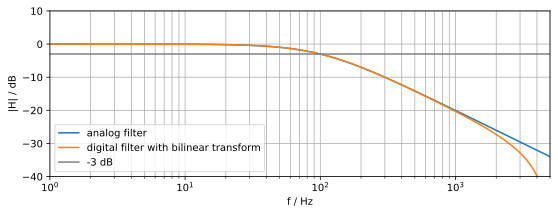

In [11]:
plt.figure(figsize=(9, 3))

fs = 10000  # sampling frequency in Hz
f = np.arange(1, fs)  # frequency in Hz
w = 2*np.pi*f  # angular frequency in rad/s
W = w/fs  # digital angular frequency in rad

wc = 2*np.pi*100  # cut-off frequency in rad/s
#wc = 2*np.pi*3000  # effect of frequency mismatch becomes obvious

# Laplace transfer
B = [0, 1]
A = [1/wc, 1]
[_, Hanalog] = signal.freqs(B, A, w)  # H

# z transfer via bilinear transform
n = 1 + 2*fs/wc
d = 1 - 2*fs/wc
b = [1/n, 1/n]
a = [1, d/n]
[_, Hbilinear] = signal.freqz(b, a, W)  # H1

plt.semilogx(f, 20*np.log10(np.abs(Hanalog)), label='analog filter')
plt.semilogx(f, 20*np.log10(np.abs(Hbilinear)),
             label='digital filter with bilinear transform')
plt.semilogx([f[0], f[-1]], [-3, -3], 'C7', label='-3 dB')
plt.ylim(-40, 10)
plt.xlim(1, fs/2)
plt.xlabel('f / Hz')
plt.ylabel('|H| / dB')
plt.legend()
plt.grid(which='both')

zero  = -b[1]/b[0]
pole = -a[1]
print('zero at:', zero, 'pole at:', pole)

Suppose we want to have the cut-off frequency exactly as desired in the digital frequency domain.

Linear mapping of $\omega_c \rightarrow \Omega_c$ gives $\Omega_c = \frac{\omega_c}{f_s}$.

This $\Omega_c$ is now inserted to the mapping 

\begin{equation}
\omega_{c,\mathrm{PRE}} = 2 f_s \tan{\frac{\Omega_c}{2}} = 2 f_s \tan{\frac{2\pi f_c}{2 f_s}}.
\end{equation}

We can easily verify that 

\begin{equation}
\Omega_c = 2 \mathrm{atan}{\frac{\omega_{c,\mathrm{PRE}}}{2 f_s}}
\end{equation}

holds we when remap and thus we obtain our desired $\Omega_c$.

Thus, instead of using $\omega_c$ in the Laplace transfer function, we use the so called **pre-warped** cut-off frequency $\omega_{c,\mathrm{PRE}}$.

## Example 2: 1st Order Lowpass Filter with Frequency Pre-Warping

Let's do this for our lowpass example. So, the code is the same with the pre-warping part being added.

zero at: -1.0 pole at: -0.15838444032453614


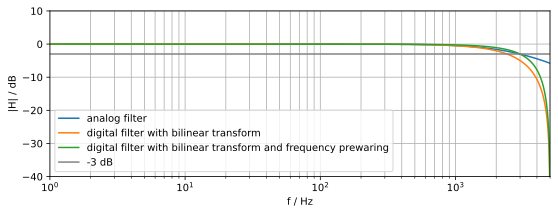

In [12]:
plt.figure(figsize=(9, 3))

fs = 10000  # sampling frequency in Hz
f = np.arange(1, fs)  # frequency in Hz
w = 2*np.pi*f  # angular frequency in rad/s
W = w/fs  # digital angular frequency in rad

wc = 2*np.pi*100  # cut-off frequency in rad/s
wc = 2*np.pi*3000  # 

# Laplace transfer
B = [0, 1]
A = [1/wc, 1]
[_, Hanalog] = signal.freqs(B, A, w)  # H

# z transfer via bilinear transform
n = 1 + 2*fs/wc
d = 1 - 2*fs/wc
b = [1/n, 1/n]
a = [1, d/n]
[_, Hbilinear] = signal.freqz(b, a, W)  # H1

# z transfer via bilinear transform with frequency pre-warping
wc_pre = 2*fs*np.tan(wc/(2*fs))
n = 1 + 2*fs/wc_pre
d = 1 - 2*fs/wc_pre
b = [1/n, 1/n]
a = [1, d/n]
[_, Hbilinear_prewarping] = signal.freqz(b, a, W)  # H2

plt.semilogx(f, 20*np.log10(np.abs(Hanalog)), label='analog filter')
plt.semilogx(f, 20*np.log10(np.abs(Hbilinear)),
             label='digital filter with bilinear transform')
plt.semilogx(f, 20*np.log10(np.abs(Hbilinear_prewarping)),
             label='digital filter with bilinear transform and frequency prewaring')
plt.semilogx([f[0], f[-1]], [-3, -3], 'C7', label='-3 dB')
plt.ylim(-40, 10)
plt.xlim(1, fs/2)
plt.xlabel('f / Hz')
plt.ylabel('|H| / dB')
plt.legend()
plt.grid(which='both')

zero  = -b[1]/b[0]
pole = -a[1]
print('zero at:', zero, 'pole at:', pole)

Again, play around with the cut-off frequency $\omega_c$. The closer it gets to $f_s/2$ the more the level responses deviate. What is the advantage of the frequency pre-warping?

## General Second Order Filter Bilinear Transform

The second order filter is very important in practical filter design, since higher-order fillters are usually split into a cascade of second order sections (SOS). Thus, it is meaningful to explicitly derive the bilinear transform of a general SOS given in Laplace domain. 

Let us denote the Laplace transfer function with real coefficients $B,A$ as
\begin{equation}
H(s)=\frac{B_0s^2+B_1s+B_2}{A_0s^2+A_1s+A_2}
\end{equation}
for a second order filter. This transfer function is to be transformed to a discrete-time filter via bilinear transform. Let us denote the $z$-transfer function with real coefficients $b,a$ as
\begin{equation}
H(z)=\frac{b_0+b_1z^{-1}+b_2z^{-2}}{1+a_1z^{-1}+a_2z^{-2}}.
\end{equation}

The aboved discussed mapping $s=2f_s\frac{z-1}{z+1}$ can be inserted to $H(s)$ to yield a representation for $H(z)$. The coefficients for this $H(z)$ can be derived to
\begin{equation}
\begin{split}
b_0=\frac{B_2+2B_1f_s+4B_0f_s^2}{A_2+2A_1f_s+4A_0f_s^2}\\
b_1=\frac{2B_2-8B_0f_s^2}{A_2+2A_1f_s+4A_0f_s^2}\\
b_2=\frac{B_2-2B_1f_s+4B_0f_s^2}{A_2+2A_1f_s+4A_0f_s^2}\\
a_1=\frac{2A_2-8A_0f_s^2}{A_2+2A_1f_s+4A_0f_s^2}\\
a_2=\frac{A_2-2A_1f_s+4A_0f_s^2}{A_2+2A_1f_s+4A_0f_s^2}.
\end{split}
\end{equation}

It is worth to note that the bilinear transform is preserving the filter order, a $n$-th order analog filter is transformed to $n$-th order discrete-time filter. There are other design methods existing that do not have this characteristics, but rather design a $m>n$-th order discrete-time filter from $n$-th order analog filter.

## Example 3: Digital Parametric Equalizer

This example was taken from Ex. 8.9 on p. 479 in Ife02. Filter parameters were modified to make the effects of pre-warping more obvious.

An analog parametric equalizer (PEQ, aka bell filter) with the Laplace transfer function

\begin{equation}
H(s)=\frac{s^2+(3+k)\frac{\omega_0}{Q}s+\omega_0^2}{s^2+(3-k)\frac{\omega_0}{Q}s+\omega_0^2} \qquad \text{with} \qquad k=3\frac{g-1}{g+1}
\end{equation}

and an amplitude factor $g$, center frequency $\omega_0=2\pi f_0$ and Q-factor
$Q$ is to be transformed into a discrete-time filter by means of the **bilinear
transform**. The filter shall exhibit a level of $G=6$ dB at center frequency $f_0=10$ kHz and a Q-factor of $Q=3$. The sampling frequency shall be $f_s = 48$ kHz.


1. Calculate the linear amplitude factor $g$ from $G$.

2. Plot the magnitude of $|H(s)|$ in dB over frequency.

3. Design $H_1(z)$ with the plain bilinear transform and plot its magnitude in dB over frequency.

4. Design $H_2(z)$ with bilinear transform and so-called frequency pre-warping
\begin{equation}
2f_s\tan{\left(\pi\frac{f_0}{f_s}\right)} \rightarrow \omega_0
\end{equation}
and plot its magnitude in dB over frequency

5. Design $H_3(z)$ with bilinear transform, frequency pre-warping and additional so-called Q-factor pre-warping (here with the tan()-function, there are other mappings as well)
\begin{equation}
2f_s\tan{\left(\pi\frac{f_0}{f_s}\right)} \rightarrow \omega_{0}
\end{equation}
\begin{equation}
\frac{\frac{\pi f_0}{f_s}}{\tan\left(\frac{\pi f_0}{f_s}\right)}\cdot Q \rightarrow Q.
\end{equation}
Plot its magnitude in dB over frequency.

6. Discuss the differences of the level responses. Especially pay attention to what happens at $f_0$, $f_s/2$ and with the bandwidth of the filter.

Ife02...Ifeachor, E.C.; Jervis, B.W. (2002): Digital Signal Processing. 2nd ed. Prentice Hall.

bilinear
b [ 1.2331693796319685 -0.6128815244504636  0.2982719778371742]
a [ 1.                 -0.6128815244504636  0.5314413574691426]
bilinear from scipy.signal
b [ 1.2331693796319685 -0.6128815244504636  0.2982719778371742]
a [ 1.                 -0.6128815244504636  0.5314413574691426]
bilinear with frequency prewarping
b [ 1.2426922276040622 -0.3914133358713037  0.2696127718841364]
a [ 1.                 -0.3914133358713037  0.5123049994881986]
bilinear with frequency AND bandwidth pre-warping
b [ 1.273051579624098  -0.3756233709915371  0.1782456803698449]
a [ 1.                 -0.3756233709915371  0.4512972599939428]


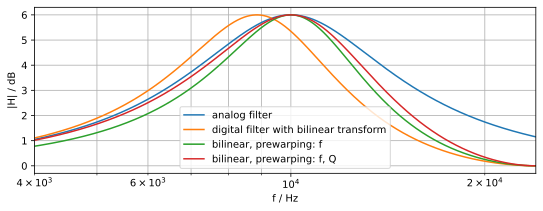

In [13]:
plt.figure(figsize=(9, 3))
# general parameter
fs = 48000  # sampling frequency in Hz
f = np.arange(100, fs)  # frequency in Hz
w = 2*np.pi*f  # angular frequency in rad/s
W = w/fs  # digital angular frequency in rad

# specific filter parameter
G = 6  # level in dB
f0 = 10000  # Hz
Q = 3  # quality

# some temp variables
g = 10**(G/20)  # level to linear gain
k = 3*(g-1)/(g+1)

# binlinear transform without any prewarping
w0 = 2*np.pi*f0
B = [1, (3+k)*w0/Q, w0**2]  # these are the coefficients of the analog filter
A = [1, (3-k)*w0/Q, w0**2]
[b, a] = bilinear_biquad(B, A, fs)  # function defined above
print('bilinear')
print('b', b)
print('a', a)
[b, a] = signal.bilinear(B, A, fs)
print('bilinear from scipy.signal')
print('b', b)
print('a', a)
[_, Hanalog] = signal.freqs(B, A, w)  # H
[_, Hbilinear] = signal.freqz(b, a, W)  # H1

# binlinear transform with frequency pre-warping
wpre = f_prewarping(f0, fs)
B = [1, (3+k)*wpre/Q, wpre**2]
A = [1, (3-k)*wpre/Q, wpre**2]
[b, a] = bilinear_biquad(B, A, fs)
print('bilinear with frequency prewarping')
print('b', b)
print('a', a)
[_, Hbilinear_wpre] = signal.freqz(b, a, W)  # H2

# binlinear transform with frequency and bandwidth pre-warping
wpre = f_prewarping(f0, fs)
Qpre = Q * (np.pi*f0 / fs) / np.tan(np.pi*f0 / fs)
B = [1, (3+k)*wpre/Qpre, wpre**2]
A = [1, (3-k)*wpre/Qpre, wpre**2]
[b, a] = bilinear_biquad(B, A, fs)
print('bilinear with frequency AND bandwidth pre-warping')
print('b', b)
print('a', a)
[_, Hbilinear_wpre_Qpre] = signal.freqz(b, a, W)  # H3

plt.semilogx(f, 20*np.log10(np.abs(Hanalog)), label='analog filter')
plt.semilogx(f, 20*np.log10(np.abs(Hbilinear)),
             label='digital filter with bilinear transform')
plt.semilogx(f, 20*np.log10(np.abs(Hbilinear_wpre)),
             label='bilinear, prewarping: f')
plt.semilogx(f, 20*np.log10(np.abs(Hbilinear_wpre_Qpre)),
             label='bilinear, prewarping: f, Q')
plt.xlim(4000, fs/2)

plt.xlabel('f / Hz')
plt.ylabel('|H| / dB')
plt.legend()
plt.grid(which='both')

# **Copyright**

The notebooks are provided as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebooks for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Frank Schultz, Digital Signal Processing - A Tutorial Featuring Computational Examples* with the URL https://github.com/spatialaudio/digital-signal-processing-exercises